# Replication of Gertler and Karadi(2015)

In [1]:
using LinearAlgebra, Statistics, Random, CSV
using DataFrames, Plots

### 1) Data

In [28]:
# data 
data = CSV.read("VAR_data.csv", DataFrame);
IND = data[1:396,4]
CPI = data[1:396,3]
TB1 = data[1:396,6]
EBP = data[1:396,11]

p  = 12
H  = 48

Y = [IND TB1 CPI EBP];

### 2) Reduced form VAR

In [5]:
# function

function reduced_VAR_OLS(Y, p)
    """
    (input)  Y: data matrix, p: lag
    (output) B: beta matrix, Sigma: var-covariance matrix, U: residual matrix
    Y_t = B_1 Y_{t-1} + B_2 Y_{t-2} + ... + B_0
    B = [B_1' B_2' ... B_p' B_0']' 형태
    """
    T, K = size(Y)
    
    # LHS
    y = Y[p+1:T, :]
    
    # RHS
    x = ones(T-p, K*p+1)
    for i=1:p
        x[:,K*(i-1)+1:K*i] = Y[p+1-i:T-i, :]
    end
    
    B = x \ y # same with "(x'*x) \ (x'*y)"
    U = y- x*B;
    Sigma = (U'*U)/(T-p - K*p-1)
    
    return B, U, Sigma, x
    
end

reduced_VAR_OLS (generic function with 1 method)

In [6]:
B, U, Sigma, x = reduced_VAR_OLS(Y, p);

### 3) IRF of Structural VAR

In [11]:
function SVAR_chol_irf(Y, p, H)
    """
    (input)  Y: data matrix, p: lag, H: horizon
    Y=[y1 y2 y3 ... yk]
    ordering: 1-2-3-...-k
    Psi_h = B1*Psi_(h-1) + B2 * Psi_(h-2) + ... + Bp*Psi_(h-p) if (h>p)
    """
    T, K = size(Y)
    B, U, Sigma, _ = reduced_VAR_OLS(Y, p)
    
    # cholesky decomposition
    A = cholesky(Sigma).L
    
    # drop the constant terms
    B_p = reshape(B[1:(end-1),:]',K,K,p);
    
    # irf
    irfs  = zeros(K,K,H);
    
    irfs[:, :, 1] = A  # impact period (h = 0)

    for h in 2:H
        irfs[:, :, h] = zeros(K, K)
        for j in 1:min(p, h - 1)
            irfs[:, :, h] += B_p[:, :, j] * irfs[:, :, h - j]
        end
    end
    
    return irfs
end

SVAR_chol_irf (generic function with 1 method)

In [12]:
irfs = SVAR_chol_irf(Y, p, H);

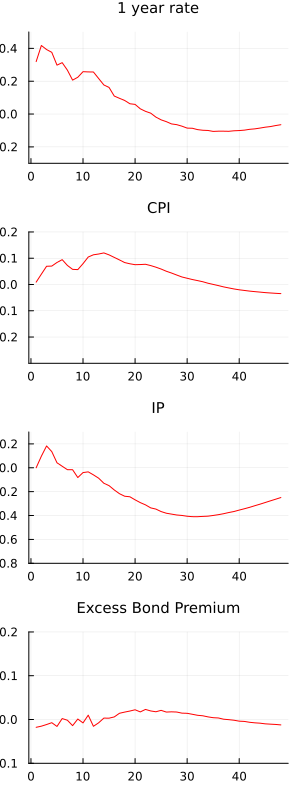

In [13]:
# graph
var_list = ["1 year rate", "CPI", "IP", "Excess Bond Premium"]
time =1:H

f1 = plot(time, irfs[2,2,:], ylim=([-0.3, 0.5]), color=:red, label="", title=var_list[1], titlefontsize=10)
f2 = plot(time, irfs[3,2,:], ylim=([-0.3, 0.2]), color=:red, label="", title=var_list[2], titlefontsize=10)
f3 = plot(time, irfs[1,2,:], ylim=([-0.8, 0.3]), color=:red, label="", title=var_list[3], titlefontsize=10)
f4 = plot(time, irfs[4,2,:], ylim=([-0.1, 0.2]), color=:red, label="", title=var_list[4], titlefontsize=10)

plot(f1, f2, f3, f4, layout = (4, 1), size = (300,800))

### 4) SE using bootstrapping

In [14]:
function bootstrap_SE(Y, p, H, N_b, CI)
    """
    Y   : endogenous variables
    p   : lag of VAR
    H   : horizon of IRF
    N_b : number of boostrapping iteration
    CI  : confidence interval significant
    """
    T, K = size(Y)
    
    # OLS
    irfs = SVAR_chol_irf(Y, p, H);
    B, U, _, x = reduced_VAR_OLS(Y, p);
        
    # detrend
    T_p, K = size(U)
    for k=1:K
        U[:,k] = U[:,k] .- mean(U[:,k])
    end

    # Bootstrapping
    irfs_set = zeros(K,K,H,N_b);
    for b=1:N_b
        # sampling from the Rademacher distribution
        # Note: common sign flipping within the same period(t)
        sign_flipping = 1 .- 2*(rand(T_p).>0.5)
        U_star = zeros(T_p,K)
        for k=1:K
            U_star[:,k] = U[:,k].*sign_flipping
        end

        # new sample
        Y_star = zeros(T, K)
        Y_star[1:p,:] = Y[1:p,:]
        for t = p+1:T
            x_t = vcat(vec(Y_star[t-1:-1:t-p, :]'), 1.0)
            for k=1:K
                Y_star[t, k] = sum(x_t .* B[:,k]) + U_star[t-p, k]
            end
        end
       
        # rerun 
        irfs_set[:,:,:,b] = SVAR_chol_irf(Y_star, p, H);    
    end
   
    # quantile confidence interval
    irfs_lower = zeros(K, K, H)
    irfs_upper = zeros(K, K, H)
    α = (1.0 - CI)/2.0
    lower_q = α
    upper_q = 1.0 - α
    for i in 1:K, j in 1:K, h in 1:H
        samples = vec(irfs_set[i, j, h, :])
        irfs_lower[i, j, h] = quantile(samples, lower_q)
        irfs_upper[i, j, h] = quantile(samples, upper_q)
    end
        
    
    return irfs, irfs_lower, irfs_upper
end    

bootstrap_SE (generic function with 1 method)

In [15]:
N_b = 1000
CI  = 0.90
irfs, irfs_lower, irfs_upper = bootstrap_SE(Y, p, H, N_b, CI);

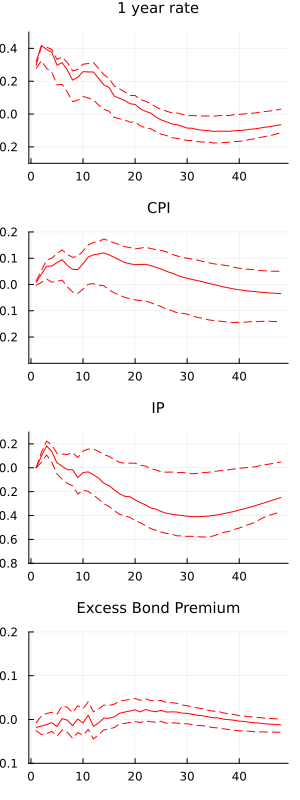

In [16]:
# graph
var_list = ["1 year rate", "CPI", "IP", "Excess Bond Premium"]
time =1:H

f1 = plot(time, irfs[2,2,:], ylim=([-0.3, 0.5]), color=:red, label="", title=var_list[1], titlefontsize=10)
plot!(f1, time, irfs_lower[2,2,:], color=:red, linestyle=:dash, label="")
plot!(f1, time, irfs_upper[2,2,:], color=:red, linestyle=:dash, label="")

f2 = plot(time, irfs[3,2,:], ylim=([-0.3, 0.2]), color=:red, label="", title=var_list[2], titlefontsize=10)
plot!(f2, time, irfs_lower[3,2,:], color=:red, linestyle=:dash, label="")
plot!(f2, time, irfs_upper[3,2,:], color=:red, linestyle=:dash, label="")

f3 = plot(time, irfs[1,2,:], ylim=([-0.8, 0.3]), color=:red, label="", title=var_list[3], titlefontsize=10)
plot!(f3, time, irfs_lower[1,2,:], color=:red, linestyle=:dash, label="")
plot!(f3, time, irfs_upper[1,2,:], color=:red, linestyle=:dash, label="")

f4 = plot(time, irfs[4,2,:], ylim=([-0.1, 0.2]), color=:red, label="", title=var_list[4], titlefontsize=10)
plot!(f4, time, irfs_lower[4,2,:], color=:red, linestyle=:dash, label="")
plot!(f4, time, irfs_upper[4,2,:], color=:red, linestyle=:dash, label="")

plot(f1, f2, f3, f4, layout = (4, 1), size = (300,800))

#savefig("GK_chol_replication.png")

### 5) SVAR-IV

In [27]:
# data 
factor = CSV.read("factor_data.csv", DataFrame)
mps = factor[139:396,4];   # instrument variables

In [19]:
function first_stage(Y, p, H, mps)
    # ordering change (GB -> 1)
    T, K = size(Y)
    T_m = length(mps)
    B, U, _, x = reduced_VAR_OLS(Y, p);
    
    # first stage
    u_GB = U[127:384,1]

    Phib = [ones(T_m,1) mps] \ u_GB
    uhat1 = [ones(T_m,1) mps] * Phib;

    b21ib11_TSLS = [ones(T_m,1) uhat1] \ U[127:384,2:end]
    b21ib11 = (b21ib11_TSLS[2:end,:])'
    
    return b21ib11
end

first_stage (generic function with 1 method)

In [20]:
function second_stage(Y, p, H, mps, b21ib11)
    # ordering change (GB -> 1)
    T, K = size(Y)
    T_m = length(mps)
    B, U, _, x = reduced_VAR_OLS(Y, p);
    
    # second stage (Mertens-Ravn(2013))
    Sigma_m = (U[127:384,:]'*U[127:384,:])/(T_m - K*p-1)

    Sig11   = Sigma_m[1,1];
    Sig21   = Sigma_m[2:K,1];
    Sig22   = Sigma_m[2:K,2:K];
    ZZp     = b21ib11*Sig11*b21ib11'-(Sig21*b21ib11'+b21ib11*Sig21')+Sig22;
    b12b12p = (Sig21- b21ib11*Sig11)'*(ZZp\(Sig21- b21ib11*Sig11));
    b11b11p = Sig11.-b12b12p;
    b11 = sqrt(b11b11p);
    b1 = [b11; b21ib11*b11]
    
    # drop the constant terms in VAR
    B_p = reshape(B[1:(end-1),:]',K,K,p);
    
    # irf
    irfs  = zeros(K,K,H); # 전체가 아니라 MP shock만 볼 수 있음
    
    irfs[:, 1, 1] = b1  # impact period (h = 0)

    for h in 2:H
        irfs[:, :, h] = zeros(K, K)
        for j in 1:min(p, h - 1)
            irfs[:, :, h] += B_p[:, :, j] * irfs[:, :, h - j]
        end
    end
    
    return irfs
end

second_stage (generic function with 1 method)

In [21]:
function SVAR_IV_IRF(Y, p, H, mps)

    # ordering change (GB -> 1)
    Y = Y[:,[2, 3, 1, 4]]
    
    # first stage
    b21ib11 = first_stage(Y, p, H, mps)
    
    # second stage (Mertens-Ravn(2013))
    irfs  = second_stage(Y, p, H, mps, b21ib11)
    
end

SVAR_IV_IRF (generic function with 1 method)

In [22]:
irfs_IV = SVAR_IV_IRF(Y, p, H, mps);

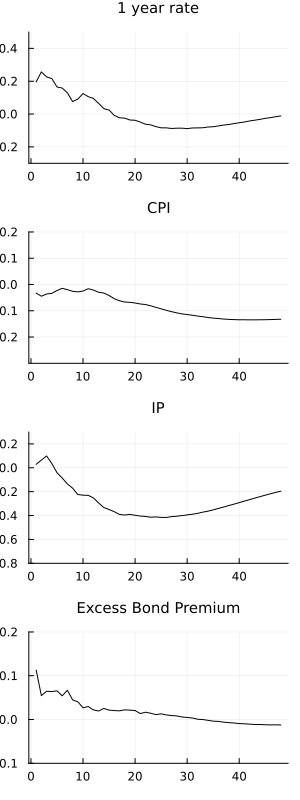

In [23]:
# graph
var_list = ["1 year rate", "CPI", "IP", "Excess Bond Premium"]
time =1:H

g1 = plot(time, irfs_IV[1,1,:], ylim=([-0.3, 0.5]), color=:black, label="", title=var_list[1], titlefontsize=10)
g2 = plot(time, irfs_IV[2,1,:], ylim=([-0.3, 0.2]), color=:black, label="", title=var_list[2], titlefontsize=10)
g3 = plot(time, irfs_IV[3,1,:], ylim=([-0.8, 0.3]), color=:black, label="", title=var_list[3], titlefontsize=10)
g4 = plot(time, irfs_IV[4,1,:], ylim=([-0.1, 0.2]), color=:black, label="", title=var_list[4], titlefontsize=10)

plot(g1, g2, g3, g4, layout = (4, 1), size = (300,800))

In [24]:
function bootstrap_SE_SVAR_IV(Y, p, H, mps, N_b, CI)
    """
    Y   : endogenous variables
    p   : lag of VAR
    H   : horizon of IRF
    N_b : number of boostrapping iteration
    CI  : confidence interval significant
    """
    # ordering change (GB -> 1)
    T, K = size(Y)
    Y = Y[:,[2, 3, 1, 4]]
    
    # OLS
    B, U, _, x = reduced_VAR_OLS(Y, p);
    
    # first stage
    b21ib11 = first_stage(Y, p, H, mps)
    # second stage
    irfs  = second_stage(Y, p, H, mps, b21ib11)
        
    # detrend
    T_p, K = size(U)
    for k=1:K
        U[:,k] = U[:,k] .- mean(U[:,k])
    end

    # Bootstrapping
    irfs_set = zeros(K,K,H,N_b);
    for b=1:N_b
        # sampling from the Rademacher distribution
        # Note: common sign flipping within the same period(t)
        sign_flipping = 1 .- 2*(rand(T_p).>0.5)
        U_star = zeros(T_p,K)
        for k=1:K
            U_star[:,k] = U[:,k].*sign_flipping
        end

        # new sample
        Y_star = zeros(T, K)
        Y_star[1:p,:] = Y[1:p,:]
        for t = p+1:T
            x_t = vcat(vec(Y_star[t-1:-1:t-p, :]'), 1.0)
            for k=1:K
                Y_star[t, k] = sum(x_t .* B[:,k]) + U_star[t-p, k]
            end
        end
       
        # rerun 
        irfs_set[:,:,:,b] = second_stage(Y_star, p, H, mps, b21ib11)
    end
   
    # quantile confidence interval
    irfs_lower = zeros(K, K, H)
    irfs_upper = zeros(K, K, H)
    α = (1.0 - CI)/2.0
    lower_q = α
    upper_q = 1.0 - α
    for i in 1:K, j in 1:K, h in 1:H
        samples = vec(irfs_set[i, j, h, :])
        irfs_lower[i, j, h] = quantile(samples, lower_q)
        irfs_upper[i, j, h] = quantile(samples, upper_q)
    end
        
    
    return irfs, irfs_lower, irfs_upper
end    

bootstrap_SE_SVAR_IV (generic function with 1 method)

In [25]:
N_b = 1000
CI  = 0.90
irfs_IV, irfs_IV_lower, irfs_IV_upper = bootstrap_SE_SVAR_IV(Y, p, H, mps, N_b, CI);

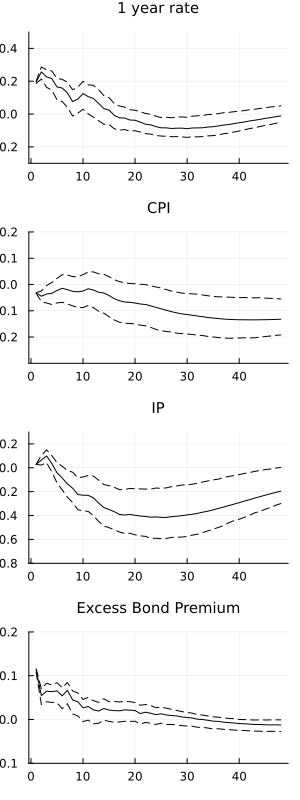

In [30]:
# graph
var_list = ["1 year rate", "CPI", "IP", "Excess Bond Premium"]
time =1:H

g1 = plot(time, irfs_IV[1,1,:], ylim=([-0.3, 0.5]), color=:black, label="", title=var_list[1], titlefontsize=10)
plot!(g1, time, irfs_IV_lower[1,1,:], color=:black, linestyle=:dash, label="")
plot!(g1, time, irfs_IV_upper[1,1,:], color=:black, linestyle=:dash, label="")

g2 = plot(time, irfs_IV[2,1,:], ylim=([-0.3, 0.2]), color=:black, label="", title=var_list[2], titlefontsize=10)
plot!(g2, time, irfs_IV_lower[2,1,:], color=:black, linestyle=:dash, label="")
plot!(g2, time, irfs_IV_upper[2,1,:], color=:black, linestyle=:dash, label="")

g3 = plot(time, irfs_IV[3,1,:], ylim=([-0.8, 0.3]), color=:black, label="", title=var_list[3], titlefontsize=10)
plot!(g3, time, irfs_IV_lower[3,1,:], color=:black, linestyle=:dash, label="")
plot!(g3, time, irfs_IV_upper[3,1,:], color=:black, linestyle=:dash, label="")

g4 = plot(time, irfs_IV[4,1,:], ylim=([-0.1, 0.2]), color=:black, label="", title=var_list[4], titlefontsize=10)
plot!(g4, time, irfs_IV_lower[4,1,:], color=:black, linestyle=:dash, label="")
plot!(g4, time, irfs_IV_upper[4,1,:], color=:black, linestyle=:dash, label="")

plot(g1, g2, g3, g4, layout = (4, 1), size = (300,800))

# savefig("GK_SVAR_IV_replication.png")